In [1]:
#https://stackoverflow.com/questions/12919980/nohup-is-not-writing-log-to-output-file
# nohup python -u ./gte.py > gte.log &
%load_ext autoreload
%autoreload 2
import os, sys
import time
import math
import glob

import torch
import torch.optim as O
import torch.nn as nn

from torch.autograd import Variable
from torchtext import data
from torchtext import datasets
from argparse import ArgumentParser

#from gte_netG import RNNnetG
from generator import Generator
import torch.optim as optim


In [2]:
import re
from custom_snli_loader import CustomSNLI
from enc_dec import EncDec

def tokenize(sent):
    '''
    data_reader.tokenize('a#b')
    ['a', '#', 'b']
    '''
    sent = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", sent) #.
    #if 'is is '
    return [x.strip().lower() for x in re.split('(\W+)?', sent) if x.strip()]

max_seq_len = 35
vocab_size = 10000
#inputs = data.Field(lower=False, fix_length=max_seq_len, init_token='<sos>')
inputs = data.Field(lower=False, fix_length=max_seq_len, tokenize=tokenize, init_token='<sos>')
answers = data.Field(sequential=False)
train, dev, test = CustomSNLI.splits(inputs, answers)
print('custom data loading debug:')
print(len(train))
print(len(dev))
print(len(test))
inputs.build_vocab(train, dev, test, max_size=vocab_size)

vector_cache = os.path.join(os.getcwd(), '.vector_cache/input_vectors.pt')
word_vectors = 'glove.42B.300d'

if os.path.isfile(vector_cache):
    inputs.vocab.vectors = torch.load(vector_cache)
else:
    #inputs.vocab.load_vectors(wv_dir=args.data_cache, wv_type=args.word_vectors, wv_dim=args.d_embed)
    print('Loading word embeddings...')
    
    inputs.vocab.load_vectors(word_vectors)
    makedirs(os.path.dirname(vector_cache))
    torch.save(inputs.vocab.vectors, vector_cache)
    

/home/gota/.pyenv/versions/3.6.2/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


custom data loading debug:
183416
3329
3368


In [36]:
gpu = 0
#rnn_type='LSTM'
rnn_type='GRU'
#resume = '3-gru_11192017/lstm_gte_best'#'lstm_gte_e22'
#resume = '3-gru-1e-4_11202017/lstm_gte_best'
#resume = 'lstm_gte_e45'
#resume = 'lstm_gte_best.pkl'
#resume = 'saves/3-gru-attn-1e-3_11222017/lstm_gte_best'


#resume = 'bahdanau_attn_3-gru_12062017/lstm_gte_e0.pkl'

#resume = 'vnmt_pretrain_12052017/vnmt_pretrain_gru_gte_best.pkl'

#resume = 'lstm_gte_best.pkl'
#resume = 'vnmt_pretrain_1-gru_12072017/vnmt_pretrain_gru_gte_best.pkl'

##resume = '3-gru_vanilla_12102017/3-vanilla_gte_best.pkl'

#resume = 'bahdanau_attn_3-gru_12062017/lstm_gte_best.pkl'
#resume = 'luong_attn_1-gru_12072017/lstm_gte_best.pkl'

#resume = 'luong_attn_3-gru_12052017/lstm_gte_best.pkl'
#resume = '1-gru_bahdanau_12102017/1-attn_gte_best.pkl'

#resume = '3-attn_gte_best.pkl'
resume = 'luong_attn_2-gru_debug/2-attn_gte_best.pkl'
if os.path.isfile(resume):
    print("=> loading checkpoint '{}'".format(resume))
    model = torch.load(resume, map_location=lambda storage, locatoin: storage.cuda(gpu))
    model.encoder.embeddings.weight.data = inputs.vocab.vectors
    model.decoder.embeddings.weight.data = inputs.vocab.vectors
    model.encoder.cuda()
    model.decoder.cuda()
else:
    print("=> no checkpoint found at '{}'".format(resume))

=> loading checkpoint 'luong_attn_2-gru_debug/2-attn_gte_best.pkl'


/home/gota/.pyenv/versions/3.6.2/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'enc_dec.EncDec' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [11]:
# run python -m visdom.server in the console before this.
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import io
import torchvision
from PIL import Image
import visdom
vis = visdom.Visdom()
import socket
hostname = socket.gethostname()

def show_plot_visdom():
    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    attn_win = 'attention (%s)' % hostname
    vis.image(torchvision.transforms.ToTensor()(Image.open(buf).convert("RGB")), win=attn_win, opts={'title': attn_win})

def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    show_plot_visdom()
    plt.show()
    plt.close()

##################################################
##################################################
27
An indian woman is washing and cleaning dirty laundry at a lake in the background is a kid who appears to have jumped into the lake .
[2, 0, 666, 15, 7, 824, 11, 425, 801, 948, 19, 3, 302, 6, 5, 107, 7, 3, 219, 182, 447, 18, 254, 1295, 81, 5, 302, 4, 1]
['<sos>', 'a', 'woman', 'is', 'watching', 'a', 'baby', '.', '<pad>']


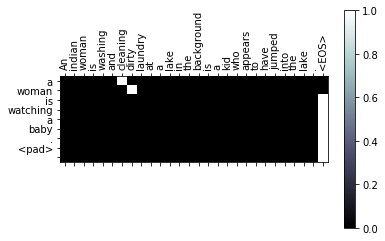

##################################################
##################################################
8
People are celebrating a victory on the square
[2, 0, 10, 1118, 3, 2348, 9, 5, 891, 1]
['<sos>', 'skiers', 'are', 'at', 'a', 'party', '.', '<pad>']


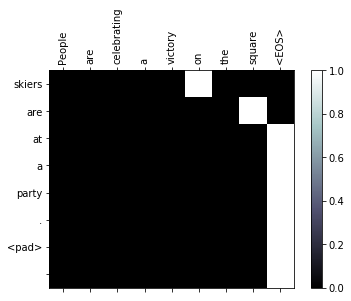

##################################################
##################################################
8
A wedding party looks happy on the picture
[2, 0, 563, 456, 110, 485, 9, 5, 95, 1]
['<sos>', 'a', 'wedding', 'is', 'happening', '.', '<pad>']


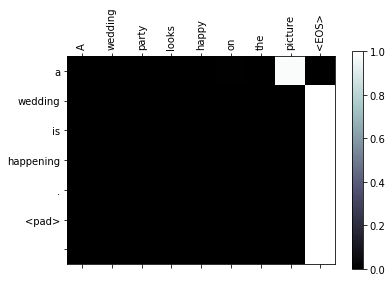

##################################################
##################################################
10
Two women who just had lunch hugging and saying goodbye.
[2, 0, 50, 182, 511, 1014, 1217, 762, 11, 1957, 0, 1]
['<sos>', 'a', 'woman', 'is', 'hugging', 'a', 'wedding', '.', '<pad>']


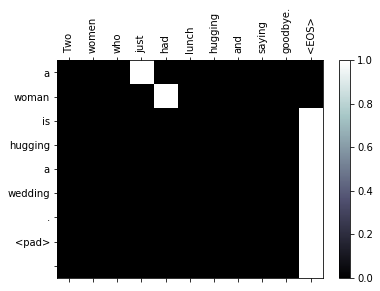

##################################################
##################################################
7
People are running away from the bear
[2, 0, 10, 74, 349, 72, 5, 1501, 1]
['<sos>', 'the', 'boys', 'are', 'running', '.', '<pad>']


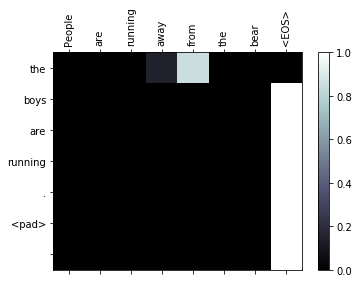

##################################################
##################################################
11
A person on a horse jumps over a broken down airplane.
[2, 0, 38, 9, 3, 190, 193, 83, 3, 1621, 45, 0, 1]
['<sos>', 'a', 'person', 'is', 'riding', 'a', 'horse', '.', '<pad>']


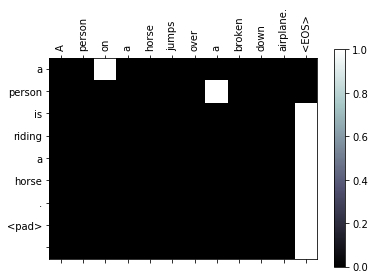

##################################################
##################################################
13
A boy is jumping on skateboard in the middle of a red bridge.
[2, 0, 30, 7, 97, 9, 251, 6, 5, 225, 12, 3, 40, 0, 1]
['<sos>', 'a', 'boy', 'is', 'jumping', '.', '<pad>']


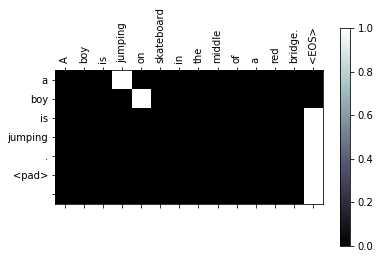

##################################################
##################################################
10
Two women who just had lunch hugging and saying goodbye.
[2, 0, 50, 182, 511, 1014, 1217, 762, 11, 1957, 0, 1]
['<sos>', 'a', 'woman', 'is', 'hugging', 'a', 'wedding', '.', '<pad>']


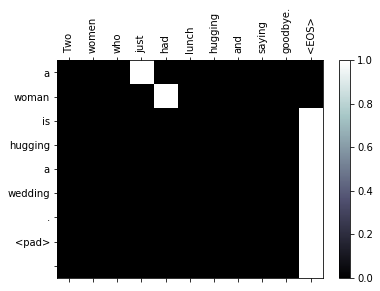

##################################################
##################################################
15
High fashion ladies wait outside a tram beside a crowd of people in the city.
[2, 0, 2792, 396, 680, 24, 3, 4713, 310, 3, 88, 12, 14, 6, 5, 0, 1]
['<sos>', 'a', 'crowd', 'of', 'people', 'wait', 'for', 'a', 'picture', '.', '<pad>']


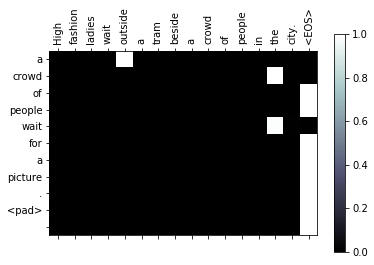

##################################################
##################################################
8
A big brown dog swims towards the camera.
[2, 0, 308, 75, 33, 1093, 301, 5, 0, 1]
['<sos>', 'a', 'dog', 'is', 'swimming', '.', '<pad>']


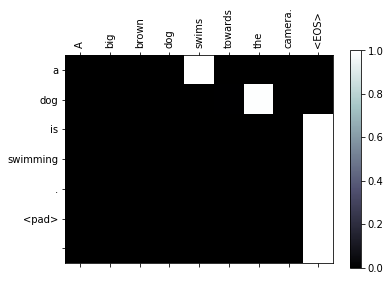

##################################################
##################################################
9
A small group of church-goers watch a choir practice.
[2, 0, 82, 39, 12, 0, 229, 3, 1249, 0, 1]
['<sos>', 'a', 'group', 'of', 'people', 'are', 'watching', 'a', 'performance', '.', '<pad>']


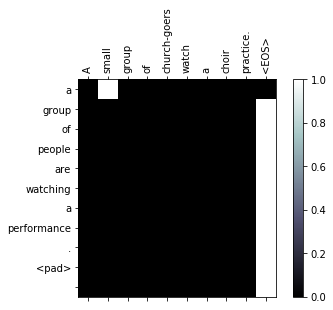

##################################################
##################################################
11
A man is surfing in a bodysuit in beautiful blue water.
[2, 0, 8, 7, 608, 6, 3, 4028, 6, 516, 37, 0, 1]
['<sos>', 'a', 'man', 'is', 'surfing', 'in', 'the', 'water', '.', '<pad>']


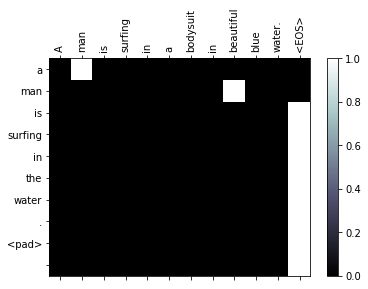

##################################################
##################################################
13
First time a computer Go program has beaten a 9-dan professional without handicaps
[2, 0, 506, 3, 424, 0, 6735, 62, 9226, 3, 0, 1027, 1083, 0, 1]
['<sos>', 'a', 'person', 'is', 'using', 'a', 'computer', '.', '<pad>']


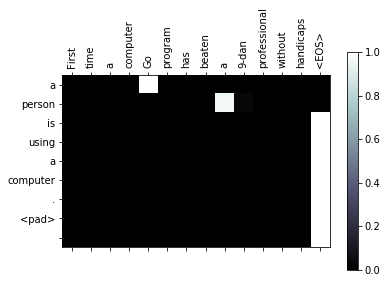

##################################################
##################################################
13
Competitors must be dressed in suitable tennis attire that is almost entirely white.
[2, 0, 3716, 217, 76, 6, 7456, 222, 659, 112, 7, 1884, 6631, 0, 1]
['<sos>', 'a', 'person', 'is', 'wearing', 'a', 'uniform', '.', '<pad>']


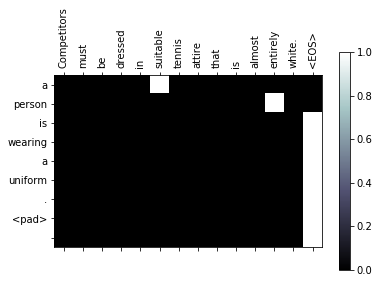

##################################################
##################################################
11
The athletes run by the harbour during the Haspa Hamburg marathon.
[2, 0, 1218, 367, 51, 5, 0, 274, 5, 0, 0, 0, 1]
['<sos>', 'athletes', 'are', 'getting', 'wet', '.', '<pad>']


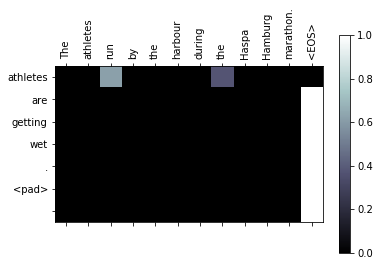

##################################################
##################################################
14
Space travellers gaze up and strain to find the blue dot in their sky. 
[2, 0, 0, 2968, 58, 11, 0, 18, 2480, 5, 37, 1841, 6, 63, 0, 1]
['<sos>', 'a', 'baby', 'is', 'being', 'held', 'by', 'a', 'person', '.', '<pad>']


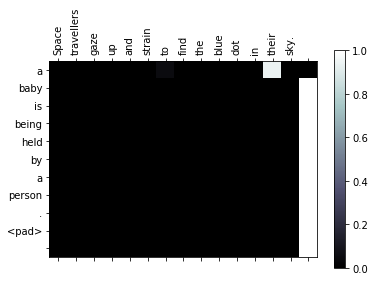

In [38]:
from time import sleep
import numpy as np
from gte import create_example
np.random.seed(1234)

ntokens = len(inputs.vocab)

#['an', 'indian', 'woman', 'is', 'washing', 'and', 'cleaning', 'dirty', 'laundry', 'at', 'a', 'lake', 'and', 'in', 'the', 'background', 'is', 'a', 'kid', 'who', 'appears', 'to', 'have', 'jumped', 'into', 'the', 'lake', '.']
#, 'the', 'background', 'is', 'a', 'kid', 'who', 'appears', 'to', 'have', 'jumped', 'into', 'the', 'lake', '.']
sents = [
    'An indian woman is washing and cleaning dirty laundry at a lake in the background is a kid who appears to have jumped into the lake .',
    
    'People are celebrating a victory on the square',
    'A wedding party looks happy on the picture',
    'Two women who just had lunch hugging and saying goodbye.',
    #'The athletes run at the start of the Haspa Hamburg marathon',
    'People are running away from the bear',
    
    'A person on a horse jumps over a broken down airplane.',
    'A boy is jumping on skateboard in the middle of a red bridge.',
    'Two women who just had lunch hugging and saying goodbye.',
    'High fashion ladies wait outside a tram beside a crowd of people in the city.',
    #'Woman in white in foreground and a man slightly behind walking with a sign for John\'s Pizza and Gyro in the background.',
    #'A woman is walking across the street eating a banana, while a man is following with his briefcase.',
    'A big brown dog swims towards the camera.',
    'A small group of church-goers watch a choir practice.',
    
    'A man is surfing in a bodysuit in beautiful blue water.',
    
    'First time a computer Go program has beaten a 9-dan professional without handicaps',
    'Competitors must be dressed in suitable tennis attire that is almost entirely white.',
    'The athletes run by the harbour during the Haspa Hamburg marathon.',
    'Space travellers gaze up and strain to find the blue dot in their sky. ',
]


for sent in sents:
    print('#'*50)
    print('#'*50)
    print(len(sent.split()))
    print(sent)
    example = create_example(inputs, sent, max_seq_len)
    print(example)
    
    if model.dec_type == 'vanilla':
        output = model.generate(inputs, ntokens, example, max_seq_len)
        print(output)
    elif model.dec_type == 'attn':
        output, attns = model.generate(inputs, ntokens, example, max_seq_len)
        print(output)
        show_attention(sent, output[1:], attns)
        sleep(1)

In [109]:
import nltk


def evaluate_bleu(test_set=dev):
    """
    Eval acc, bleu, etc.
    """

    # Turn on evaluation mode which disables dropout.
    model.encoder.eval()
    model.decoder.eval()
    mean_bleu = 0
    skipped = 0
    mean_bleu_long=0
    count = 0
    
    # take mean by lengths
    interval = 5
    mean_bleu_length = [0] * int(max_seq_len/interval)
    mean_bleu_count = [0] * int(max_seq_len/interval)
    
    for pair_idx, pair in enumerate(test_set):
        #input = ['<sos>']+pair.premise+['<pad>']
        input = pair.premise
        
        
        # Avoid index out of range error
        if len(input) >= max_seq_len-1:
            skipped += 1
            continue
        
        example = create_example(' '.join(input), len(input))
        if model.dec_type == 'vanilla':
            prediction = generate(model, ntokens, example)
        elif model.dec_type == 'attn':
            prediction,attn = generate(model, ntokens, example)

        bleu = nltk.translate.bleu_score.sentence_bleu(pair.hypothesis, prediction)
        
        # for computing average mean over the whole dataset
        mean_bleu += bleu
        
        #print(input)
        #print(example)
        #print(prediction)
        
        
        
        with open('results/dev_3-gru_vanilla.txt', 'a') as the_file:
        #with open('results/dev_3-gru_bahdanau.txt', 'a') as the_file:
        #with open('results/dev_3-gru_luong.txt', 'a') as the_file:
            the_file.write(' '.join(prediction) + '\n')    
        # for per-length average bleus
        #with open('dev_reference.txt', 'a') as the_file:
        #    the_file.write(' '.join(pair.hypothesis) + '\n')
        
        length = len(input)
        for i in range(len(mean_bleu_length)):
            if length > i*interval and length <= (i+1)*interval:
                with open('results/dev_3-gru_vanilla_len%d.txt'%( (i+1)*interval ), 'a') as the_file:
                #with open('results/dev_3-gru_bahdanau_len%d.txt'%( (i+1)*interval ), 'a') as the_file:
                #with open('results/dev_3-gru_luong_len%d.txt'%( (i+1)*interval ), 'a') as the_file:
                    the_file.write(' '.join(prediction) + '\n')
                    
                # save refernce as well
                #with open('results/dev_reference_len%d.txt'%( (i+1)*interval ), 'a') as the_file:
                #    the_file.write(' '.join(pair.hypothesis) + '\n')
                mean_bleu_length[i] += bleu
                mean_bleu_count[i] += 1

        
        # hard-coded ver
        if len(pair.premise) > 20:
            #print('#'*50)
            #print(input)
            #print(prediction)
            #print(bleu)
            mean_bleu_long += bleu
            count+=1
        
        if pair_idx % 100 == 0 and pair_idx > 0:
            print(pair_idx)
            #print(mean_bleu/float(pair_idx-skipped))
            #print(interval)
            #print(length)
            #print(mean_bleu_count)
            #for i in range(len(mean_bleu_length)):
            #    if mean_bleu_count[i] != 0:
            #        mean_bleu_length[i] /= float(mean_bleu_count[i])
            #print(mean_bleu_length)
            
    for i in range(len(mean_bleu_length)):
        if mean_bleu_count[i] != 0:
            mean_bleu_length[i] /= float(mean_bleu_count[i])
    print('skipped examples=%d'%skipped)
    print('mean bleus by length:')
    print(mean_bleu_length)
    print('sent counts by length:')
    print(mean_bleu_count)
    print('mean bleu for longer sentences')
    print( mean_bleu_long/float(count) )
                                             
    return mean_bleu/float(len(test_set)-skipped)



In [110]:
print(evaluate_bleu(dev))
print('=============')
#print(evaluate_bleu(test))

/home/gota/.pyenv/versions/3.6.2/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2900
3000
3100
3200
3300
skipped examples=68
mean bleus by length:
[0.269942566551301, 0.42696817319489705, 0.48730276116769067, 0.4922813455047118, 0.5136647552637371, 0.5308847307025911, 0.6103163593021327]
sent counts by length:
[29, 814, 1123, 668, 448, 152, 27]
mean bleu for longer sentences
0.5220013255599785
0.4780006740647543


In [ ]:
### dev set

# vanilla 3-gru 1e-3
#0.6197822029399289
#0.6173733465746407

## Bahdanau's attn 3-gru
#80
#0.6195196003064333
#0.6192209814956989

## Luong's attn 3-gru


In [ ]:
0.0
0.7215811598543795 # 3-GRU w/o attention when trained w/ 1e-3 on dev
train_iter, val_iter, test_iter = data.BucketIterator.splits(
            (train, dev, test), batch_size=256, device=0)
len(train_iter)

In [15]:
def evaluate_val_pred():
    # Turn on evaluation mode which disables dropout.
    model.encoder.eval()
    model.decoder.eval()
    mean_bleu = 0

    for pair_idx, pair in enumerate(dev):
        
        
        #input = ['<sos>']+pair.premise+['<pad>']
        input = pair.premise
        
        # Avoid index out of range error
        if len(input) >= max_seq_len-1:
            continue
        
        #print(type(input))
        #print(' '.join(input))
        example = create_example(' '.join(input), len(input))
        prediction = generate(model, ntokens, example)
        #prediction,attn = generate(model, ntokens, example)
        print('#'*50)
        print(len(input))
        print(input)
        print(pair.hypothesis)
        print(prediction)

        if pair_idx % 100 == 0 and pair_idx > 0:
            return

evaluate_val_pred()

##################################################
10
['two', 'women', 'are', 'embracing', 'while', 'holding', 'to', 'go', 'packages', '.']
['two', 'woman', 'are', 'holding', 'packages', '.']
['<sos>', 'two', 'women', 'are', 'hugging', '.', '<pad>']
##################################################
18
['a', 'man', 'selling', 'donuts', 'to', 'a', 'customer', 'during', 'a', 'world', 'exhibition', 'event', 'held', 'in', 'the', 'city', 'of', 'angeles']
['a', 'man', 'selling', 'donuts', 'to', 'a', 'customer', '.']
['<sos>', 'a', 'man', 'records', 'to', 'a', 'clearly', '.', '<pad>']
##################################################
17
['two', 'young', 'boys', 'of', 'opposing', 'teams', 'play', 'football', ',', 'while', 'wearing', 'full', 'protection', 'uniforms', 'and', 'helmets', '.']
['boys', 'play', 'football']
['<sos>', 'football', 'players', 'are', 'playing', 'football', '.', '<pad>']
##################################################
20
['a', 'man', 'in', 'a', 'blue', 'shirt', 'stand

##################################################
11
['a', 'little', 'boy', 'in', 'a', 'blue', 'shirt', 'holding', 'a', 'toy', '.']
['boy', 'dressed', 'in', 'blue', 'holds', 'a', 'toy', '.']
['<sos>', 'a', 'boy', 'is', 'holding', 'a', 'toy', '.', '<pad>']
##################################################
28
['a', 'woman', 'is', 'writing', 'something', 'on', 'a', 'post', '-', 'it', 'note', 'which', 'is', 'hanging', 'on', 'a', 'bulletin', 'board', 'with', 'a', 'lot', 'of', 'other', 'post', '-', 'it', 'notes', '.']
['the', 'woman', 'is', 'writing', 'a', 'note', '.']
['<sos>', 'a', 'woman', 'is', 'writing', '.', '<pad>']
##################################################
13
['a', 'baby', 'at', 'the', 'end', 'of', 'a', 'slip', 'and', 'slide', 'at', 'a', 'party']
['the', 'baby', 'is', 'wet', '.']
['<sos>', 'a', 'baby', 'is', 'at', 'a', 'party', '.', '<pad>']
##################################################
13
['a', 'baby', 'at', 'the', 'end', 'of', 'a', 'slip', 'and', 'slide', 'at', 'a',

##################################################
9
['girl', 'plays', 'with', 'colorful', 'letters', 'on', 'the', 'floor', '.']
['the', 'girl', 'is', 'having', 'fun', 'learning', 'her', 'letters', '.']
['<sos>', 'the', 'girl', 'is', 'playing', 'a', 'game', '.', '<pad>']
##################################################
13
['two', 'men', 'are', 'cooking', 'food', 'together', 'on', 'the', 'corner', 'of', 'the', 'street', '.']
['the', 'men', 'are', 'making', 'something', 'to', 'eat', '.']
['<sos>', 'two', 'men', 'cooking', '.', '<pad>']
##################################################
12
['a', 'man', 'wandering', 'in', 'the', 'desert', 'as', 'the', 'clouds', 'roll', 'in', '.']
['a', 'man', 'wonders', 'in', 'the', 'desert', '.']
['<sos>', 'a', 'man', 'is', 'in', 'the', 'water', '.', '<pad>']
##################################################
11
['a', 'lady', 'with', 'bright', 'orange', 'hair', 'walking', 'in', 'a', 'crowd', '.']
['a', 'woman', 'is', 'near', 'a', 'group', 'of', 'people'

##################################################
15
['a', 'carefully', 'balanced', 'male', 'stands', 'on', 'one', 'foot', 'near', 'a', 'clean', 'ocean', 'beach', 'area', '.']
['a', 'man', 'is', 'ouside', 'near', 'the', 'beach', '.']
['<sos>', 'a', 'man', 'stands', 'on', 'a', 'beach', '.', '<pad>']
##################################################
11
['a', 'man', 'wearing', 'a', 'white', 'shirt', 'is', 'playing', 'the', 'drums', '.']
['a', 'man', 'is', 'playing', 'a', 'musical', 'instrument', '.']
['<sos>', 'a', 'man', 'is', 'playing', 'an', 'instrument', '.', '<pad>']
##################################################
10
['three', 'women', 'in', 'dress', 'suits', 'walk', 'by', 'a', 'building', '.']
['three', 'women', 'are', 'traveling', 'by', 'foot', '.']
['<sos>', 'three', 'women', 'are', 'walking', 'outside', '.', '<pad>']
##################################################
11
['two', 'people', 'are', 'waiting', 'for', 'a', 'train', 'at', 'a', 'station', '.']
['they', 'expect', 'a'

In [26]:
def evaluate_val_pred():
    # Turn on evaluation mode which disables dropout.
    model.encoder.eval()
    model.decoder.eval()
    mean_bleu = 0
    print(max_seq_len)
    for pair_idx, pair in enumerate(dev):
        
        
        input = pair.premise
        #input = ['<sos>']+pair.premise+['<pad>']
        #print(input)
        if len(input) > max_seq_len-2:
            continue
        
        #print(type(input))
        #print(' '.join(input))
        if len(input) > 20:
            #example = create_example(inputs, ' '.join(input), len(input))
            example = create_example(' '.join(input), len(input))
            #print(example)
            
            #prediction = generate(model, inputs, ntokens, example, max_seq_len)
            ##prediction,attn = generate(model, ntokens, example)
            prediction,attn = generate(model, ntokens, example)
            
            print('#'*50)
            print(input)
            print(pair.hypothesis)
            print(prediction)
            #show_attention('<sos> ' + ' '.join(input) + ' <pad>', prediction, attns)

        if pair_idx % 500 == 0 and pair_idx > 0:
            return

evaluate_val_pred()

35


TypeError: create_example() missing 1 required positional argument: 'max_seq_len'